## Embedding
We start by developing an embedding of a dictionary. Since all potential words and misspellings that are in tweets would create an extremely large, but sparse vector, this would not be an efficient way of storing data.

The most common solution is to represent each word in the vocabulary using a fairly small and dense vector called an *embedding*, and just let the neural network learn a good embedding for each word during training. At the beginning of training, embeddings are simply chosen randomly, but during training, backpropagation automatically moves the embeddings around in a way that helps the neural network perform its task. This means that similar words will gradually cluster close to one another, and even end up organized in a rather meaningful way. Embeddings may end up placed along various axes that represent gender, singular/plural, adjective/noun, etc.

We first need to create the variable representing the embedding, then if we feed a sentence to the neural network, we first preprocess the sentence and break it into a list of known words. We may remove unnecessary characters, replace unknown words by a predefined token word such as "[UNK]", replace numerical values by "[NUM]", replace URLs with "[URL]", and so on. Once we have a list of known words, we can look up each word's integer identifier in a dictionary. At that point we are ready to feed these word identifiers to TensorFlow using a placeholder, and apply the `embedding_lookup()` function to get the corresponding embeddings.

Once our model has learned good word embeddings, they can actually be reused fairly efficiently in any NLP application. In fact, instead of training our own word embeddings, we may want to download pretrained word embeddings (like using pretrained layers, we can choose to freeze the pretrained embeddings by creating an `embeddings` variable using `trainable = False`, or let backpropagation tweak them for our application. The first option will speed up training, but the second may lead to slightly higher performance.

We form the dictionary from tweets scraped by keyword (list of 50 terms in `data-cleaner.ipynb`), and data collected from `twitter_samples` of the Natural Language Toolkit (`nltk`) database.

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import textblob

from six.moves import urllib

import errno
import os
import zipfile

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Old code for downloading the Twitter data from ntlk. **DID NOT QUITE WORK.**

```python
TWEET_PATH = "datasets/twitter_samples"
TWEET_URL = 'http://www.nltk.org/nltk_data/twitter_samples.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
def fetch_tweet_data(tweet_url=TWEET_URL, tweet_path=TWEET_PATH):
    os.makedirs(tweet_path, exist_ok=True)
    zip_path = os.path.join(tweet_path, "twitter_samples.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(tweet_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()
```

In [11]:
from nltk.corpus import twitter_samples
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [12]:
twitter_samples.strings()[:5]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(']

In [13]:
tweets = twitter_samples.tokenized()
tweet_dict = []
for i in range(len(tweets)):
    for j in range(len(tweets[i])):
        tweet_dict.append(tweets[i][j])


print(tweet_dict[:10])

tweet_words = np.array(tweet_dict)

['hopeless', 'for', 'tmr', ':(', 'Everything', 'in', 'the', 'kids', 'section', 'of']


In [3]:
scraped_tweets = pd.read_csv('datasets/water_tweets/un_gathered_h2o_tweets.csv', encoding = 'ISO-8859-1', delimiter = ';')
scraped_tweets = scraped_tweets.iloc[:, 1:]
print(len(scraped_tweets))
scraped_tweets.head()

50422


,tweet_id,tweet,time_stamp,retweets
0,1.140000e+18,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,6/25/2019 20:45,0
1,1.140000e+18,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,6/25/2019 20:28,0
2,1.140000e+18,So the maintenance men at my apartment complex...,6/25/2019 20:21,0
3,1.140000e+18,".@NWStulsa issued 1,530 flood/flash flood prod...",6/25/2019 20:07,0
4,1.140000e+18,"They might not call it a #climatedebate, but c...",6/25/2019 19:55,0


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
tweet_text = np.array(scraped_tweets.tweet.astype(str))

tweet_list = []
for i in range(len(tweet_text)):
    tweet = tweet_text[i]
    tweet_list.append(tweet)
tweet_list[:5]

["@LeslieWalden6 @MookieTheBrave @AngusMcPussPuss @AngelaStillwell @cat_samson @arkantart @Biscuit_Meow @duchess_meow @TobiasandJasper @goodman_carina It's cwazy!! Mom tiwed of seeing flash flood warnings fwom The Weather Channel pop up on her phone evewyday. She appweciates the warning, but she knows which aweas are pwone to flooding.Ã°Â\x9fÂ\x98Â¼Ã°Â\x9fÂ\x98Â¼",
 '4 PASSES to FLASH FLOOD WATER PARK in Battle Creek, MICHIGAN - 2019 season!!! $12.00 | #WaterparkTickets | https://t.co/tIumVg5T0d Grab Your Tickets https://t.co/UQNz5zZ7vC',
 'So the maintenance men at my apartment complex are leaf blowing during a flash flood warning... https://t.co/YkWkVzTvSy',
 '.@NWStulsa issued 1,530 flood/flash flood products in May 2019 alone!  Includes new warnings/advisories + all follow up statements #okwx #arwx https://t.co/3M9GfJyuez',
 'They might not call it a #climatedebate, but considering that the venue where 20 Democrats are meeting in Miami this week was once inundated during a flash fl

In [6]:
from textblob import TextBlob
tweets = np.array(tweet_list)
tweet_list = []
for t in range(len(tweets)):
    new = TextBlob(tweets[t])
    tweet_list.append(new)

In [7]:
rel_h2o_words = []
for i in range(len(tweet_list)):
    tweet_i = tweet_list[i]
    new_words = tweet_i.words
    rel_h2o_words.append(new_words)

In [8]:
from itertools import chain
rel_h2o_words = np.array(list(chain(*rel_h2o_words)))

In [14]:
new_dict = np.concatenate([tweet_words, rel_h2o_words])

In [15]:
print(len(new_dict))

2074449


## Build Our Dictionary

In [17]:
from collections import Counter

vocabulary_size = 40000

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("UNK", None)] + [("HST", None)] + [("EMT", None)] + [("URL", None)] + [("THDL", None)] +\
            Counter(new_dict).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in tweet_words])

In [19]:
" ".join(new_dict[:9]), data[:9]

('hopeless for tmr :( Everything in the kids section',
 array([22775,    14, 27422,    53,  3811,    11,     5,   468,  5836]))

In [20]:
" ".join([vocabulary[word_index] for word_index in [22775,    14, 27422,    53,  3811,    11,     5,   468,  5836]])

'hopeless for tmr :( Everything in the kids section'

## Generate Batches

In [21]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [22]:
np.random.seed(42)

data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [23]:
batch, [vocabulary[word] for word in batch]

(array([   14,    14, 27422, 27422,    53,    53,  3811,  3811]),
 ['for', 'for', 'tmr', 'tmr', ':(', ':(', 'Everything', 'Everything'])

In [24]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[27422],
        [22775],
        [   53],
        [   14],
        [27422],
        [ 3811],
        [   11],
        [   53]]),
 ['tmr', 'hopeless', ':(', 'for', 'tmr', 'Everything', 'in', ':('])

In [25]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 32     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [26]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

vocabulary_size = 40000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

W0718 14:25:18.624912 16532 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  295.02587890625
Nearest to me: commentary, Saving, 9News, S, @BrendanOHaraSNP, solder, jayvee1964, Gore,
Nearest to THDL: gluino78, DP, erramanzin, Mobile, Reservoir, CMO_Odisha, #SNPcult, @Historywoman,
Nearest to we: plasticfreejuly, fluid, ÃÂ¶, Bangladesh, mail, knee, Child, microorganisms,
Nearest to up: clearly, Students, bled, tub, likewise, Bulletin, VERY, only,
Nearest to a: silently, wadewoodworker, Dollars, Globe, All, targeting, professionalism, inviting,
Nearest to has: http://t.co/fOSJKQZM2z, Warrington, Addresses, @queenbeeof90, scaring, places, i'd, #LongTermEconomicPlan,
Nearest to drinking: Confidence, designated, #kik, Bernard, CleanEnergy, https://t.co/dOQzNPtif0, drpsrao, requests,
Nearest to like: Ukraine, watches, PIKE, lure, leaching, Religious, Ã¢ÂÂTrump, THO,
Nearest to was: Movember, Assistant, striving, ausmedia, Kenyans, filtersÃÂ, soreness, MdWx,
Nearest to in: starts, chased, @RichardDawkins, chequered, Outlook, 

In [28]:
np.save("./my_final_embeddings_tweets.npy", final_embeddings)

## Plotting the Embedding

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 149 missing from current font.
  f

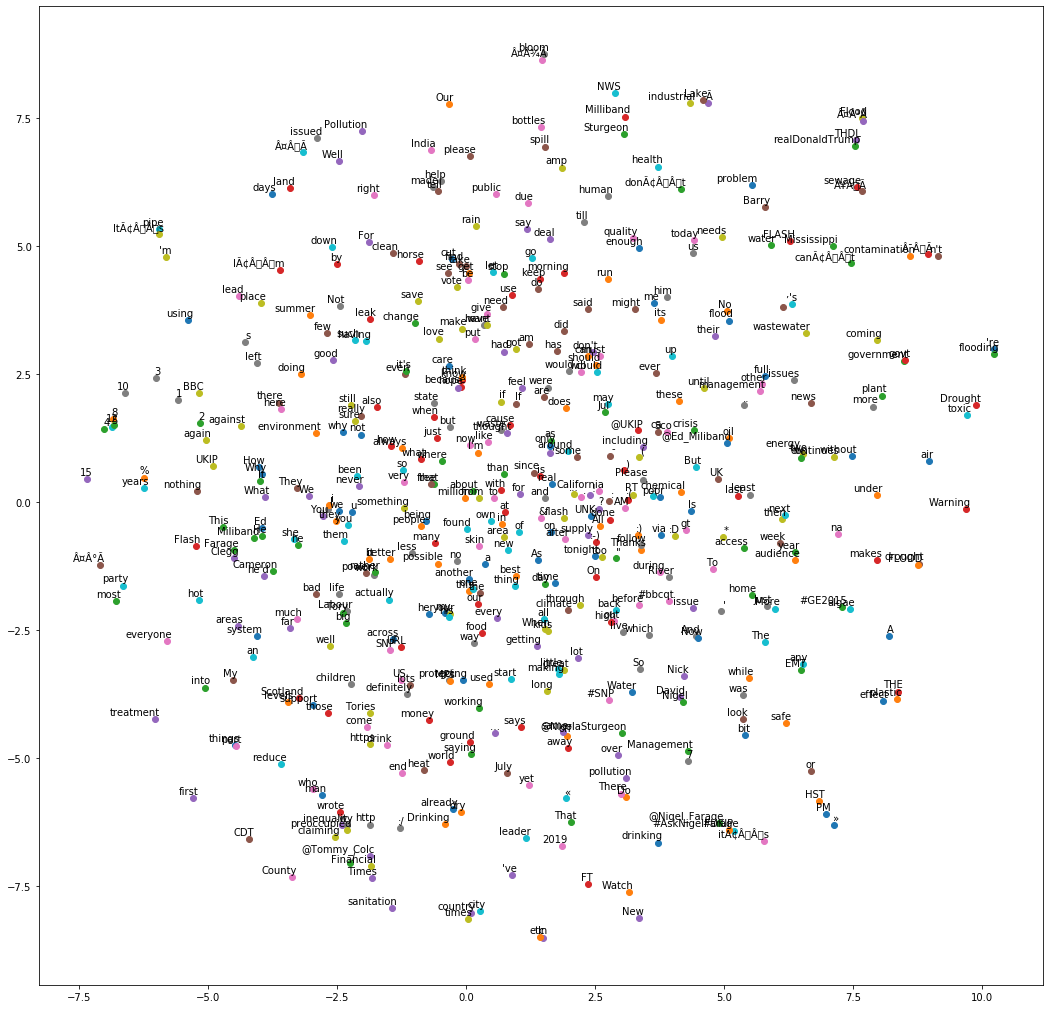

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)